In [1]:
import gc
import os
from os.path import exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../input/lish-moa/train_features.csv')
test = pd.read_csv('../input/lish-moa/test_features.csv')
train['part']='train'
test['part']='test'
# df = pd.concat([tr, te], axis=0)
cs_c = ["#c0c", "#0cc", "#cc0", "#000"]
# del tr, te
gc.collect()

0

In [4]:
i_feats = ['sig_id']
x_feats = ['cp_type', 'cp_time', 'cp_dose']
g_feats = [f'g-{i}' for i in range(772)] # 772
c_feats = [f'c-{i}' for i in range(100)]

## cp_timeごとに、各C特徴で訓練/テストの分布を比較

In [13]:
def train_test_plot(tr, te, colname, colset, feats, suffix=""):
    feats_ = np.array(feats).reshape((-1,10))
    for batch_idx, feats_batch in enumerate(feats_):
        num_c = len(feats_batch)
        num_s = len(colset)
        fig, axes = plt.subplots(num_c, num_s, figsize=(5,10), sharex=True, sharey=True)
        fig.suptitle("train(magenta) vs test(yellow)")
        for j, ci in enumerate(feats_batch):
            print(f'batch {batch_idx:>3} / {len(feats_)}, plotting {j:>3} / {num_c:>3}', end='\r')
            for i, t in enumerate(colset):
                tr[tr[colname] == t][ci].plot(kind='kde', ax=axes[j][i], label="train", color=cs_c[0])
                te[te[colname] == t][ci].plot(kind='kde', ax=axes[j][i], label="test", color=cs_c[2])
                axes[j][i].grid(True)
            axes[j][0].set_ylabel(ci)
        for i, t in enumerate(colset):
            axes[0][i].set_title(f'time: {t}')
            axes[0][i].set_xlim(-10,10)
            
        dir_ = f"image/tr-te_feats_by_{colname}_{suffix}"
        if not exists(dir_):
            os.makedirs(dir_)
        plt.savefig(f"{dir_}/{feats_batch[0]}.pdf")
        plt.close()

## cp_timeごとのc特徴

In [15]:
cp_times = [24,48,72]
train_test_plot(train, test, 'cp_time', cp_times, c_feats)

## cp_doseごとのc特徴

In [10]:
cp_dose = ['D1', 'D2']
train_test_plot(train, test, 'cp_dose', cp_dose, c_feats)

## cp_typeごとのc特徴

In [11]:
cp_type = ["trt_cp", "ctl_vehicle"]
train_test_plot(train, test, 'cp_type', cp_type, c_feats)

## trt_cpのみでcp_timeごとのc特徴、cp_doseごとのc特徴

In [14]:
train_test_plot(train[train['cp_type']=='trt_cp'], 
                test[test['cp_type']=='trt_cp'], 
                'cp_time', cp_times, c_feats, suffix="trt_cp")

In [19]:
train_test_plot(train[train['cp_type']=='trt_cp'], 
                test[test['cp_type']=='trt_cp'], 
                'cp_dose', cp_dose, c_feats, suffix="trt_cp")

---

## PCAによる特徴の再現性検証

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer

In [59]:
y = []
coef = 10
for g_comp in [2,4,8,16,32,48,64,96,128,196,256,384,512]:
    n_quantiles = 1000
    gdf = train[g_feats].values
    gpca = PCA(n_components=g_comp)
    g = gpca.fit_transform(gdf)
    coverage = gpca.explained_variance_ratio_.sum()
    y.append([g_comp,coverage])
    print(f"{g_comp:>3}:{coverage:<.3}", end='\r')

In [60]:
yr = []
coef = 10
for g_comp in [2,4,8,16,32,48,64,96,128,196,256,384,512]:
    n_quantiles = 1000
    gqt = QuantileTransformer(n_quantiles=n_quantiles, random_state=42)
    gdf = gqt.fit_transform(train[g_feats])
    gpca = PCA(n_components=g_comp)
    g = gpca.fit_transform(gdf)
    coverage = gpca.explained_variance_ratio_.sum()
    yr.append([g_comp,coverage])
    print(f"{g_comp:>3}:{coverage:<.3}", end='\r')

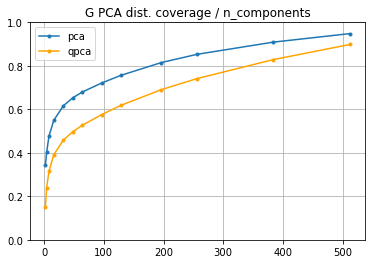

In [61]:
y = pd.DataFrame(y, columns=['g_comp', 'coverage'])
yr = pd.DataFrame(yr, columns=['g_comp', 'coverage'])
plt.plot(y['g_comp'], y['coverage'], marker='.', label='pca')
plt.plot(yr['g_comp'], yr['coverage'], marker='.', color='orange', label='qpca')
plt.grid(True)
plt.ylim(0,1)
plt.title('G PCA dist. coverage / n_components')
plt.legend()
plt.show()

In [62]:
y = []
coef = 10
for c_comp in [1,2,3,4,5,6,8,10,15,20,25,30,40,50,75,100]:
    n_quantiles = 1000
    cdf = train[c_feats].values
    cpca = PCA(n_components=c_comp)
    c = cpca.fit_transform(cdf)
    coverage = cpca.explained_variance_ratio_.sum()
    y.append([c_comp,coverage])
    print(f"{c_comp:>3}:{coverage:<.3}", end='\r')

In [63]:
yr = []
coef = 10
for c_comp in [1,2,3,4,5,6,8,10,15,20,25,30,40,50,75,100]:
    n_quantiles = 1000
    cdf = cqt.fit_transform(cdf)    
    cpca = PCA(n_components=c_comp)
    c = cpca.fit_transform(cdf)
    coverage = cpca.explained_variance_ratio_.sum()
    yr.append([c_comp,coverage])
    print(f"{c_comp:>3}:{coverage:<.3}", end='\r')

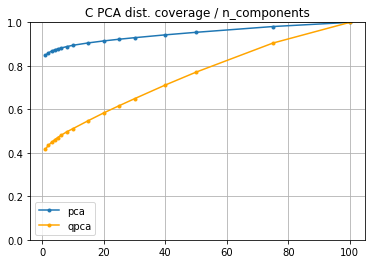

In [65]:
y = pd.DataFrame(y, columns=['c_comp', 'coverage'])
yr = pd.DataFrame(yr, columns=['c_comp', 'coverage'])
plt.plot(y['c_comp'], y['coverage'], marker='.', label='pca')
plt.plot(yr['c_comp'], yr['coverage'], marker='.', color='orange', label='qpca')
plt.grid(True)
plt.ylim(0,1)
plt.title('C PCA dist. coverage / n_components')
plt.legend()
plt.show()